# Import Necessary Modules/Packages

In [1]:
!pip install GPy
!pip uninstall -y ipdb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 959 kB 4.1 MB/s 
     |████████████████████████████████| 71 kB 9.9 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565129 sha256=6cfca61f21329e2f21bf8beda7765ba252b3536c4147f6774b3ff9d13350e40c
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=09360fe2601a25e574f32a65ce685731c6909c796483b4f3ed5c1c90fd59e0d2
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz


In [2]:
import GPy
import numpy as np
import math # math operation
from matplotlib import pyplot as plt # make plot
#import random
from tqdm import tqdm
import timeit
import copy
%matplotlib inline
%load_ext autoreload
from sklearn.metrics import confusion_matrix
from scipy.stats import norm
import pickle
import itertools
import pandas as pd


# Data Processing

## Define a function for Data Simulation: 
Three datasets will be built and each with sample size of 2000 (n = 2000)

In [3]:
def data_simulation(x,funct = 0):
  """
  1.Descrption:

          This function simulates data based on a model below,
          and gives output of f(x) and y. 
          
          The model: y = sigmoid(f(x)).
          Where f is a latent function, and error follows normal distribution N(0,2)

          There are three latent functions f in the data_simulation function, see item 2
  
  2. input arguments and output:
      Input arguments:
          x: features
          funct: Decide what f to use, there are two types.

          n: sample size of x
          seed: to make result reproducible
      Output:
          simulated data: a tuple with (f(x),y) 

  """
  # Data simulation
  fx1 = 5*np.sin(x) 
  tmp = 0 
  for i in range(1,6):
    tmp += np.sin(i*x) 
    

  fx2 = 5*tmp

  py1 = norm.cdf(fx1) 

  # label is derived by binomial distribution
  one_container = np.array([1 for i in range(len(x))])
  y1 = np.random.binomial(one_container, py1)

  # y1 = copy.deepcopy(py1)
  # y1[y1 >= 0.5] = 1
  # y1[y1 < 0.5] = 0

  py2 = norm.cdf(fx2)
  y2 = np.random.binomial(one_container, py2)

  # y2= copy.deepcopy(py2)
  # y2[y2 >= 0.5] = 1
  # y2[y2 < 0.5] = 0

  y = [y1,y2] 
  f = [fx1,fx2]
  p = [py1, py2]
  return y[funct], f[funct], p[funct]
  


def get_train_test(train_size = 100, test_size = 100, funct = 0, interval = (-2,2), seed = 123):
  np.random.seed(seed)
  train_x = np.random.uniform(*interval,train_size)
  train_y,train_f,train_p = data_simulation(train_x,funct = funct)
  test_x = np.linspace(*interval, test_size)
  test_y, test_f, test_p = data_simulation(test_x,funct = funct)
  return train_x, train_y, train_p, test_x, test_y, test_p




def get_train_test_spa(train_size = 100, test_size = 100, funct = 0, interval = (-2,2), seed = 123):

  """
  The function is to used to test different split of spa
  """

  np.random.seed(seed)

  mu, sigma = 0, 0.8 # mean and standard deviation
  train_x = np.random.normal(mu, sigma, train_size)
  train_x[np.where(train_x <-2)] = -2
  train_x[np.where(train_x > 2)] = 2


  train_y,train_f,train_p = data_simulation(train_x,funct = funct)
  test_x = np.linspace(*interval, test_size)
  test_y, test_f, test_p = data_simulation(test_x,funct = funct)
  return train_x, train_y, train_p, test_x, test_y, test_p






# Cross validation function

In [4]:
def cross_valid(x, y, k_fold = 5):


    # set seed
    seed = 123
    np.random.seed(seed)

    hypers = {'Outputscale': [0.1,1,5,10,30],'Lengthscale': [0.1,1,5,10,30]}
    tmp = [hypers['Outputscale'], hypers['Lengthscale']]
    hyperset = list(itertools.product(*tmp))
    #debug
    hyper_error = []

    k = k_fold # 5 folds
    size, subsize = x.shape[0], x.shape[0]//k
    ind = [i for i in range(len(x))]
    np.random.shuffle(ind)

    models_cv_loss = np.zeros((k,len(hyperset)))
    for i in range(k):
      if i != (k-1):
        sta, end = subsize * i, subsize*(i+1)
      else:
        sta, end = subsize * i, None
      #print(f"\n sta: {sta}; end {end}")
      for m in range(len(hyperset)):
        # shuffle index
        ind_all = [j for j in range(size)]
        test_ind = ind[sta:end]
        train_ind = [ind for ind in ind_all if ind not in test_ind]

        
        
        train_x = x[train_ind]

        try:
          # fit model
          model = model_build(x = train_x,y = y[train_ind],kernel_par= hyperset[m])

          # Evaluation 

          test_x = x[test_ind]
          test_y = y[test_ind]

          pred_y,_ = model.predict(test_x.reshape(-1,1), full_cov=False, include_likelihood=True)
          pred_y[pred_y >= 0.5] = 1
          pred_y[pred_y < 0.5] = 0
          loss = np.mean(pred_y.reshape(-1,1) != test_y.reshape(-1,1))


          # This is another loss calculation method
          # one_vec = np.array([1 for i in range(len(pred_y))])
          # pred_y_label = np.random.binomial(one_vec, pred_y.reshape(-1))
          # loss = np.mean(pred_y_label.reshape(-1,1) != test_y.reshape(-1,1))

          models_cv_loss[i,m] = loss


        # Try except is to avoid some mis-behalfed hyerparameters
        except:
          hyper_error.append(hyperset[m])
          models_cv_loss[i,m] = float('inf')
          print(f"The hyperpar with exception: {hyper_error}")
          

        
      # if i == 0: 
      #   print(f"\n sample size: {x.shape[0]}; train size: {train_x.shape}; test size: {test_x.shape}\n")
    loss = np.mean(models_cv_loss, axis = 0)
    optimhyper = hyperset[np.argmin(loss)]
    return loss, optimhyper
      


# Full Model


In [5]:
def model_build(x,y,kernel_par, seed = 123):
  """
  1.Descrption:
          This function is to build models with different hyperparameters
  
  2. input arguments and output:
      Input arguments:
          x: Features
          y: True response value
          kernel: String. Square_exp or Matern
          kernel_par: A tuple. (outputscale, lengthscale, noise)
          seed: Int. To make result reproducible
          iter_num: Int. Number of epochs for training
      Output:
          model and likelihood

  """
  # kernel = "square_exp",
  # set seed
  np.random.seed(seed)



  # build model
  outputscale, lenscale = kernel_par
  lik = GPy.likelihoods.Bernoulli()

  kernel = GPy.kern.RBF(input_dim=1,variance= outputscale,lengthscale= lenscale)
  model = GPy.core.GP(x.reshape(-1,1),
                      y.reshape(-1,1),
                      kernel = kernel, 
                      inference_method=GPy.inference.latent_function_inference.Laplace(),
                      likelihood=lik)

  #m.optimize('bfgs', max_iters=100) Because CV applied, we did not used the optimize  
  return model

# Distributed Method Specification

##spa

partition with equal sample

In [6]:
def To_interval_equal_sample(x,y,m):
  """
  To partion for spatial subsampling.
  Output: three list of array: each array corespond to a machine
  """
  x_m = [[] for i in range(m)]
  y_m = [[] for i in range(m)]
  size = []
  x, y = copy.deepcopy(x), copy.deepcopy(y)

  x, y = zip(*sorted(zip(x, y)))
  distance = int(len(x)/m) 
  interval = [x[distance * (i+1)] if i+1 != m else x[distance * (i+1)-1] for i in range(m)] # out of range
  interval[-1] = float("inf")
  #print(f"The interval len is {len(interval)}")
  for a_x, a_y in zip(x,y):
      for i in range(len(interval)):
        if a_x <= interval[i]:
          x_m[i].append(a_x)
          y_m[i].append(a_y)
          break
  x_m = [np.array(array) for array in x_m]
  y_m = [np.array(array) for array in y_m]
  size = [len(np.array(array)) for array in x_m]
  print(f"the size for each machines {size}")
  return  interval, x_m, y_m

partition with equal subrange

In [7]:
# all chuncks are for Saptial
def To_interval(x,y,m):
  """
  To partion for spatial subsampling.
  Output: three list of array: each array corespond to a machine
  """
  x_m = [[] for i in range(m)]
  y_m = [[] for i in range(m)]
  x, y = copy.deepcopy(x), copy.deepcopy(y)
  x, y = zip(*sorted(zip(x, y)))
  distance = (x[-1]-x[0])/m
  interval = [x[0] + distance * (i+1) for i in range(m)]
  interval[-1] = float("inf")
  #print(f"The interval len is {len(interval)}")
  for a_x, a_y in zip(x,y):
      for i in range(len(interval)):
        if a_x <= interval[i]:
          x_m[i].append(a_x)
          y_m[i].append(a_y)
          break
  x_m = [np.array(array) for array in x_m]
  y_m = [np.array(array) for array in y_m]
  size = [len(np.array(array)) for array in x_m]
  print(f"having zero to 2? {[0 in size, 1 in size, 2 in size]}")

  return  interval, x_m, y_m


def prediction_spa(test_x,interval,modelcontainer):
  """
  The function is about latent f
  This function give the list of list. Include x, cov and mean.
  The number of element is decided by number of machine 

  """
  m = len(interval)
  mean = []
  cov = []
  x_m = [[] for i in range(m)]

  test_x = copy.deepcopy(test_x)
  test_x = np.sort(test_x)
  for a_x in test_x:
    for i in range(len(interval)):
      if a_x <= interval[i]:
        x_m[i].append(a_x)
        break
  x_m = [np.array(array) for array in x_m]

  for i in range(len(x_m)):
    model = modelcontainer[i] 

    # mean_spa means the predicted mean
    mean_spa, cov_spa = model.predict(x_m[i].reshape(-1,1), full_cov=True, include_likelihood=False)
    mean.append(mean_spa)
    cov.append(cov_spa)

    

  #y_flaten = np.array([j for i in y for j in i])
  return  x_m, cov, mean

def derive_pi_spa(mean_lst,cov_lst,simu_num = 200,seed = 212):
    """
    To get pi from laten f for spatial method
    """
    prob = []
    for mean, cov in zip(mean_lst,cov_lst):
      #print(f"mean is {mean}")
      p_chunk = derive_pi(mean,cov,simu_num,seed)
      prob.append(p_chunk)
    rlst_prob = np.array([p for p_chunk in prob for p in p_chunk])
    return prob, rlst_prob




def distributed_model_spa(x, y, machine_num = 10, seed = 213, equal_region = True):


    # set seed
    np.random.seed(seed)

    m = machine_num #  machines
    size, subsize = x.shape[0], x.shape[0]//m
    ind = [i for i in range(len(x))]
    np.random.shuffle(ind)

    model_container = []

    if equal_region:
      intv, m_x_lst, m_y_lst = To_interval(x, y, m = m)
      print(f"The interval is: {np.round(intv,1)}")
    else:
      intv, m_x_lst, m_y_lst = To_interval_equal_sample(x, y, m = m)
      print(f"The interval is: {np.round(intv,1)}")

    for i in range(m):
                
        m_x = m_x_lst[i]
        m_y = m_y_lst[i]
        if len(m_x)<5:
          k_spa =  len(m_x)
          print(f"k_spa {k_spa}")
        else:
          k_spa = 5
        _, optim = cross_valid(m_x, m_y, k_fold = k_spa)
        #print(f"optim is {optim}")
        model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= optim)
        model_container.append(model)

    return model_container

## general

In [8]:
def distributed_model(x, y, machine_num = 10, seed = 213, mode = "naiveAvg"):


    # set seed
    np.random.seed(seed)

    m = machine_num #  machines
    size, subsize = x.shape[0], x.shape[0]//m
    ind = [i for i in range(len(x))]
    np.random.shuffle(ind)

    
    model_container = []
    if mode == "naiveAvg":

      for i in range(m):

          if i != (m-1):
            sta, end = subsize * i, subsize*(i+1)
          else:
            sta, end = subsize * i, None
          # print(f"\n {i}th machine")

        
          indice = ind[sta:end]
          m_x = x[indice]
          m_y = y[indice]

          _, optim = cross_valid(m_x, m_y, k_fold = 5)
          #print(f"optim is {optim}")
          model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= optim)
          model_container.append(model)
    elif mode == "adjPrior":

      for i in range(m):

        if i != (m-1):
          sta, end = subsize * i, subsize*(i+1)
        else:
          sta, end = subsize * i, None
        #print(f"\n {i}th machine: \n sta: {sta}; end {end}")

      
        indice = ind[sta:end]
        m_x = x[indice]
        m_y = y[indice]
        _, optim = cross_valid(m_x, m_y, k_fold = 5) 


        outscale, lenscale = optim
        #print(f"optim is {optim}")
        model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= (m*outscale, lenscale))
        model_container.append(model)


    elif mode == "spa":
      _, m_x_lst, m_y_lst = To_interval(x, y, m = m)

      for i in range(m):
                 
          m_x = m_x_lst[i]
          m_y = m_y_lst[i]
          if len(m_x)<5:
            k_spa =  len(m_x)
            print(f"k_spa {k_spa}")
          else:
            k_spa = 5
          _, optim = cross_valid(m_x, m_y, k_fold = k_spa)
          #print(f"optim is {optim}")
          model = model_build(x = m_x.reshape(-1,1),y = m_y.reshape(-1,1),kernel_par= optim)
          model_container.append(model)


    return model_container
# derive cov and mean for each machine:




def derive_cov_mean(x,model_container):
    """
    derive mean and cov of latent f for each machine
    """
    test_x = x
    mean_container = []
    cov_container = []
    for model in model_container:
      mean, cov = model.predict(test_x.reshape(-1,1), full_cov=True, include_likelihood=False)
      mean_container.append(mean)
      cov_container.append(cov)
    
    return mean_container, cov_container



def combine_method(mean_container, cov_container, mode):
    """
    Take averge of mean of predictive distribution from all machine
    Take averge of covariance of predictive distribution from all machine
    predictive distribution is p(f*|x,y,x*)

    """
    mean_container = np.array(mean_container)
    cov_container = np.array(cov_container)
    combine_mean = np.mean(mean_container,axis = 0)

    if mode == "naiveAvg":
      combine_cov = np.mean(cov_container,axis = 0)/len(mean_container)
    elif mode == "adjPrior":
      combine_cov = np.mean(cov_container,axis = 0)

    return combine_mean,combine_cov


# derive combined cov and mean:

def get_full_par(x,y,test_x, mode,machine_num):
  """
  The function is derived combined mean and covariance of latent f
  x,y: train data
  mode is either naiveAvg or adjPrior
  """
  model_container = distributed_model(x,y, mode = mode,machine_num = machine_num)
  est_para = derive_cov_mean(test_x,model_container)
  mean, cov = combine_method(*est_para, mode = mode)
  return mean, cov





def derive_pi(mean,cov,simu_num = 200,seed = 212):
    """

    Monte Carlo integration is applied
    transform f into p(y =1|x)

    """

    np.random.seed(seed)
    contianer = []
    for i in range(simu_num):
      f_str = np.random.multivariate_normal(mean.reshape(-1), cov)
      realizatoin =  norm.cdf(f_str)
      contianer.append(realizatoin)
      

    rslt = np.array(contianer)
    prob = np.mean(rslt, axis=0)
    return prob


# Metrics

In [9]:
def get_confusion_matrix(test_y1, pred_y):
  predy_dist =  copy.deepcopy(pred_y)
  predy_dist[predy_dist >= 0.5] = 1
  predy_dist[predy_dist < 0.5] = 0
  return confusion_matrix(test_y1, predy_dist, labels=[0,1])


# The complete simlation experiment

In [10]:
def main_fun(x,y, test_x,test_y,mode = "naiveAvg", machine_num = 5, spa_equal_region = True):
  """
  The goal is to derive the plot, model, result from all kinds of distributed models
  Method: naive, adjPrior, spa


  Output: 
  """

  rslt = {"time": None, "confusion": None,"pre_p_sort":None}
  time = None
  if mode != "spa":
     start = timeit.default_timer()
     mean, cov = get_full_par(x = x,y = y,test_x = test_x, mode = mode,machine_num = machine_num)
     stop = timeit.default_timer()
     time = stop - start

     rslt["time"] = time
     p = derive_pi(mean, cov,simu_num = 200,seed = 212)
     tn, fp, fn, tp = get_confusion_matrix(test_y, p).ravel()

     rslt["confusion"] = (tn, fp, fn, tp)


     x_sort, pre_p = zip(*sorted(zip(test_x, p)))
     rslt["pre_p_sort"] = (x_sort, pre_p, mean, cov)

  elif mode == "spa":

    # spa 
    start = timeit.default_timer()
    model_container = distributed_model_spa(x = x, y = y,machine_num = machine_num,equal_region= spa_equal_region)
    stop = timeit.default_timer()
    time = stop - start
    rslt["time"] = time

    # derive sorted x coordinate, spa cov and mean list
    if  spa_equal_region:
      interval_spa, _,_ = To_interval(x, y, m = machine_num)
    else:
      interval_spa, _,_ = To_interval_equal_sample(x, y, m = machine_num)
    x_spa, cov_spa, mean_spa = prediction_spa(test_x,interval_spa,model_container)

    p_chunk_spa, p_flatten_spa = derive_pi_spa(mean_spa,cov_spa,simu_num = 200,seed = 212)

    tn, fp, fn, tp  = get_confusion_matrix(test_y, p_flatten_spa).ravel()


    rslt["confusion"] = (tn, fp, fn, tp)
    rslt["pre_p_sort"] = (x_spa, p_chunk_spa, cov_spa, mean_spa)

  return rslt

  

# Implementation1

In [11]:
#data_container = {500:None,1000:None,3000:None,6000:None}
max_n = 4000
data_container = {800:None,1600:None,2400:None, 3200:None, max_n:None}
test_size = 500
for n in data_container:
  data = get_train_test(train_size = n, test_size = test_size, funct = 1, interval = (-2,2), seed = 123)
  data_container[n] = data



In [ ]:
modes = ["spa",'naiveAvg','adjPrior']
machine = [1,5,10,20,100]
result_container = dict()
for mode in modes:
  for n, data in data_container.items():
    for m in machine:
      train_x, train_y, train_p, test_x, test_y, test_p = data
      rslt = main_fun(train_x, train_y, test_x,test_y,mode = mode, machine_num = m)
      result_container[(n,m)] = rslt

      print(f"\n We finished in mode = {mode}, n = {n}, m = {m}: Time:{round(rslt['time'],2)}\n")



      # if n == 3000:
      #   with open(f'rslt_{mode}_3000.pickle', 'wb') as handle:
      #     pickle.dump(result_container, handle)

  
  with open(f'rslt_{mode}_{max_n}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)
  result_container = dict()


having zero to 2? [False, False, False]
The interval is: [inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 1: Time:71.74

having zero to 2? [False, False, False]
The interval is: [-1.2 -0.4  0.4  1.2  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 5: Time:33.06

having zero to 2? [False, False, False]
The interval is: [-1.6 -1.2 -0.8 -0.4 -0.   0.4  0.8  1.2  1.6  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 10: Time:35.16

having zero to 2? [False, False, False]
The interval is: [-1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2 -0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 800, m = 20: Time:36.71

having zero to 2? [False, False, False]
The interval is: [-2.  -1.9 -1.9 -1.8 -1.8 -1.8 -1.7 -1.7 -1.6 -1.6 -1.6 -1.5 -1.5 -1.4
 -1.4 -1.4 -1.3 -1.3 -1.2 -1.2 -1.2 -1.1 -1.1 -1.  -1.  -1.  -0.9 

 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(10, 1)]
The hyperpar with exception: [(10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1), (30, 1)]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 3200, m = 1: Time:1304.24

having zero to 2? [False, False, False]
The interval is: [-1.2 -0.4  0.4  1.2  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 3200, m = 5: Time:214.96

having zero to 2? [False, False, False]
Th

 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(10, 1)]
The hyperpar with exception: [(10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 4000, m = 1: Time:2419.66

having zero to 2? [False, False, False]
The interval is: [-1.2 -0.4  0.4  1.2  inf]
having zero to 2? [False, False, False]

 We finished in mode = spa, n = 4000, m = 5: Time:345.29

having zero to 2? [False, False, False]
The interval is: [-1.6 -1.2 -0.8 -0.4 -0.   0.4  0.8  1.2  1.6  inf]
having zero to 2? [False, False, False]

 We

In [12]:
modes = ['naiveAvg','adjPrior']
machine = [1,5,10,20,100]
result_container = dict()
for mode in modes:
  for n, data in data_container.items():
    for m in machine:
      train_x, train_y, train_p, test_x, test_y, test_p = data
      rslt = main_fun(train_x, train_y, test_x,test_y,mode = mode, machine_num = m)
      result_container[(n,m)] = rslt

      print(f"\n We finished in mode = {mode}, n = {n}, m = {m}: Time:{round(rslt['time'],2)}\n")



      # if n == 3000:
      #   with open(f'rslt_{mode}_3000.pickle', 'wb') as handle:
      #     pickle.dump(result_container, handle)

  
  with open(f'rslt_{mode}_{max_n}.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)
  result_container = dict()


 We finished in mode = naiveAvg, n = 800, m = 1: Time:69.48


 We finished in mode = naiveAvg, n = 800, m = 5: Time:34.85


 We finished in mode = naiveAvg, n = 800, m = 10: Time:28.46


 We finished in mode = naiveAvg, n = 800, m = 20: Time:48.86


 We finished in mode = naiveAvg, n = 800, m = 100: Time:144.04


 We finished in mode = naiveAvg, n = 1600, m = 1: Time:249.12


 We finished in mode = naiveAvg, n = 1600, m = 5: Time:73.51


 We finished in mode = naiveAvg, n = 1600, m = 10: Time:70.97


 We finished in mode = naiveAvg, n = 1600, m = 20: Time:56.9


 We finished in mode = naiveAvg, n = 1600, m = 100: Time:150.84


 We finished in mode = naiveAvg, n = 2400, m = 1: Time:567.25


 We finished in mode = naiveAvg, n = 2400, m = 5: Time:133.68


 We finished in mode = naiveAvg, n = 2400, m = 10: Time:102.06


 We finished in mode = naiveAvg, n = 2400, m = 20: Time:114.51


 We finished in mode = naiveAvg, n = 2400, m = 100: Time:155.48



 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(10, 1)]
The hyperpar with exception: [(10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]

 We finished in mode = naiveAvg, n = 3200, m = 1: Time:1127.7


 We finished in mode = naiveAvg, n = 3200, m = 5: Time:217.93


 We finished in mode = naiveAvg, n = 3200, m = 10: Time:139.63


 We finished in mode = naiveAvg, n = 3200, m = 20: Time:142.49


 We finished in mode = naiveAvg, n = 3200, m = 100: Time:163.39



 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(10, 1)]
The hyperpar with exception: [(10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]

 We finished in mode = naiveAvg, n = 4000, m = 1: Time:1963.9


 We finished in mode = naiveAvg, n = 4000, m = 5: Time:325.49


 We finished in mode = naiveAvg, n = 4000, m = 10: Time:190.83


 We finished in mode = naiveAvg, n = 4000, m = 20: Time:164.9


 We finished in mode = naiveAvg, n = 4000, m = 100: Time:251.7


 We finished in mode = adjPrior, n = 800, m = 1: Time:67.6


 We finished in mode = adjPrior, n = 800, m = 5: Tim

 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(10, 1)]
The hyperpar with exception: [(10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]

 We finished in mode = adjPrior, n = 3200, m = 1: Time:1180.9


 We finished in mode = adjPrior, n = 3200, m = 5: Time:221.23


 We finished in mode = adjPrior, n = 3200, m = 10: Time:138.43


 We finished in mode = adjPrior, n = 3200, m = 20: Time:141.33


 We finished in mode = adjPrior, n = 3200, m = 100: Time:166.98



 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(10, 1)]
The hyperpar with exception: [(10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (10, 1)]
The hyperpar with exception: [(10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1), (10, 1), (30, 1)]

 We finished in mode = adjPrior, n = 4000, m = 1: Time:2060.77


 We finished in mode = adjPrior, n = 4000, m = 5: Time:322.08


 We finished in mode = adjPrior, n = 4000, m = 10: Time:193.38


 We finished in mode = adjPrior, n = 4000, m = 20: Time:174.54


 We finished in mode = adjPrior, n = 4000, m = 100: Time:250.84



# Result


## Table

In [14]:

filename = ['rslt_naiveAvg_4000.pickle', "rslt_adjPrior_4000.pickle",'rslt_spa_4000.pickle']

file_dic = {'naiveAvg':None, 'adjPrior':None, 'spa':None}

for i, key in zip(range(3),file_dic):
  with open(filename[i], "rb") as f:
      dictname = pickle.load(f)
      print(f"key is {key}; filename is {filename[i]}")
      file_dic[key] = dictname

key is naiveAvg; filename is rslt_naiveAvg_4000.pickle
key is adjPrior; filename is rslt_adjPrior_4000.pickle
key is spa; filename is rslt_spa_4000.pickle


In [13]:
def to_df(method_dic, time = True):
  method = method_dic
  data = dict()
  row_index = []
  for key in method:
    n,m = key

    t = round(method[key]['time'],2)
    tn, fp, fn, tp = method[key]['confusion']
    fpr = fp/(fp + tn) *100
    fnr = fn/(fn + tp) *100
    mcr = (fp + fn)/ (tn + fp + fn + tp) *100
    if time:
      ele = f"{round(t,2)}"
    else:
      ele = f"(FPR: {round(fpr,2)}, FNR:{round(fnr,2)}, MCR:{round(mcr,2)})"

    if f"m = {m}" in data.keys():
      data[f"m = {m}"] += [ele]
    else:
      data[f"m = {m}"] = [ele]

    if f"n = {n}" not in row_index:
      row_index.append(f"n = {n}")
  df = pd.DataFrame(data,index=row_index)
  return df


In [28]:
#naive avg
df1 = to_df(file_dic['naiveAvg'], time = False)
print(df1.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                           m = 1 &                           m = 5 &                          m = 10 &                          m = 20 &                           m = 100 \\
\midrule
n = 800  &  (FPR: 6.35, FNR:7.66, MCR:7.0) &  (FPR: 7.14, FNR:6.45, MCR:6.8) &  (FPR: 7.94, FNR:6.45, MCR:7.2) &  (FPR: 7.94, FNR:5.24, MCR:6.6) &  (FPR: 11.51, FNR:8.87, MCR:10.2) \\
n = 1600 &  (FPR: 7.45, FNR:5.71, MCR:6.6) &  (FPR: 6.27, FNR:6.12, MCR:6.2) &  (FPR: 7.84, FNR:6.12, MCR:7.0) &  (FPR: 6.27, FNR:9.39, MCR:7.8) &  (FPR: 10.98, FNR:9.39, MCR:10.2) \\
n = 2400 &  (FPR: 5.62, FNR:4.78, MCR:5.2) &  (FPR: 6.02, FNR:5.18, MCR:5.6) &  (FPR: 6.02, FNR:5.18, MCR:5.6) &  (FPR: 8.43, FNR:4.38, MCR:6.4) &    (FPR: 8.84, FNR:9.56, MCR:9.2) \\
n = 3200 &    (FPR: 5.2, FNR:3.2, MCR:4.2) &    (FPR: 5.2, FNR:4.0, MCR:4.6) &    (FPR: 5.6, FNR:4.4, MCR:5.0) &   (FPR: 11.6, FNR:6.8, MCR:9.2) &   (FPR: 10.8, FNR:10.4, MCR:10.6) \\
n = 4000 &  (FPR: 5.86, FNR:4.92, MCR:5.4) &

In [29]:
# adj prior
df2 = to_df(file_dic['adjPrior'], time = False)
print(df2.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                           m = 1 &                           m = 5 &                          m = 10 &                          m = 20 &                            m = 100 \\
\midrule
n = 800  &  (FPR: 6.35, FNR:7.66, MCR:7.0) &  (FPR: 7.14, FNR:6.85, MCR:7.0) &  (FPR: 7.94, FNR:6.85, MCR:7.4) &  (FPR: 7.14, FNR:6.45, MCR:6.8) &   (FPR: 9.52, FNR:11.69, MCR:10.6) \\
n = 1600 &  (FPR: 7.45, FNR:5.71, MCR:6.6) &  (FPR: 5.88, FNR:6.53, MCR:6.2) &  (FPR: 7.45, FNR:5.71, MCR:6.6) &  (FPR: 4.31, FNR:8.16, MCR:6.2) &  (FPR: 10.98, FNR:12.65, MCR:11.8) \\
n = 2400 &  (FPR: 5.62, FNR:4.78, MCR:5.2) &  (FPR: 6.02, FNR:5.18, MCR:5.6) &  (FPR: 5.22, FNR:5.18, MCR:5.2) &  (FPR: 7.63, FNR:3.98, MCR:5.8) &     (FPR: 8.84, FNR:9.56, MCR:9.2) \\
n = 3200 &    (FPR: 5.2, FNR:3.2, MCR:4.2) &    (FPR: 4.8, FNR:3.6, MCR:4.2) &    (FPR: 5.6, FNR:4.4, MCR:5.0) &    (FPR: 6.8, FNR:4.0, MCR:5.4) &    (FPR: 10.4, FNR:11.6, MCR:11.0) \\
n = 4000 &  (FPR: 5.86, FNR:4.92, MCR:5

In [30]:
# Spa prior
df3 = to_df(file_dic['spa'], time = False)
print(df3.to_latex(index=True))  
# The first column is different from other two because there is a shuffle partitioning. Which will derive different optim when doing CV

\begin{tabular}{llllll}
\toprule
{} &                           m = 1 &                           m = 5 &                          m = 10 &                          m = 20 &                         m = 100 \\
\midrule
n = 800  &  (FPR: 6.35, FNR:7.26, MCR:6.8) &  (FPR: 6.35, FNR:6.85, MCR:6.6) &  (FPR: 6.35, FNR:6.85, MCR:6.6) &  (FPR: 6.35, FNR:7.26, MCR:6.8) &  (FPR: 6.35, FNR:8.47, MCR:7.4) \\
n = 1600 &  (FPR: 7.06, FNR:5.71, MCR:6.4) &  (FPR: 7.84, FNR:6.12, MCR:7.0) &  (FPR: 6.67, FNR:5.71, MCR:6.2) &  (FPR: 7.84, FNR:5.31, MCR:6.6) &  (FPR: 5.88, FNR:6.94, MCR:6.4) \\
n = 2400 &  (FPR: 6.02, FNR:5.18, MCR:5.6) &  (FPR: 6.43, FNR:5.98, MCR:6.2) &  (FPR: 8.03, FNR:4.38, MCR:6.2) &  (FPR: 7.23, FNR:4.78, MCR:6.0) &  (FPR: 7.23, FNR:4.78, MCR:6.0) \\
n = 3200 &    (FPR: 6.0, FNR:5.2, MCR:5.6) &    (FPR: 4.8, FNR:4.8, MCR:4.8) &    (FPR: 6.8, FNR:4.4, MCR:5.6) &    (FPR: 4.8, FNR:3.2, MCR:4.0) &    (FPR: 4.8, FNR:4.8, MCR:4.8) \\
n = 4000 &  (FPR: 6.25, FNR:4.51, MCR:5.4) &  (FPR: 5.

In [15]:
df1 = to_df(file_dic['naiveAvg'])
print(df1.to_latex(index=True))  

df2 = to_df(file_dic['adjPrior'])
print(df2.to_latex(index=True))  

df3 = to_df(file_dic['spa'])
print(df3.to_latex(index=True))

\begin{tabular}{llllll}
\toprule
{} &   m = 1 &   m = 5 &  m = 10 &  m = 20 & m = 100 \\
\midrule
n = 800  &   69.48 &   34.85 &   28.46 &   48.86 &  144.04 \\
n = 1600 &  249.12 &   73.51 &   70.97 &    56.9 &  150.84 \\
n = 2400 &  567.25 &  133.68 &  102.06 &  114.51 &  155.48 \\
n = 3200 &  1127.7 &  217.93 &  139.63 &  142.49 &  163.39 \\
n = 4000 &  1963.9 &  325.49 &  190.83 &   164.9 &   251.7 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllll}
\toprule
{} &    m = 1 &   m = 5 &  m = 10 &  m = 20 & m = 100 \\
\midrule
n = 800  &     67.6 &    35.7 &   28.22 &   50.31 &  148.33 \\
n = 1600 &   258.85 &   74.47 &   80.29 &   58.22 &   153.7 \\
n = 2400 &    578.9 &  139.23 &  103.46 &  128.18 &  156.38 \\
n = 3200 &   1180.9 &  221.23 &  138.43 &  141.33 &  166.98 \\
n = 4000 &  2060.77 &  322.08 &  193.38 &  174.54 &  250.84 \\
\bottomrule
\end{tabular}

\begin{tabular}{llllll}
\toprule
{} &    m = 1 &   m = 5 &  m = 10 &  m = 20 & m = 100 \\
\midrule
n = 800  &    71.74 &   3

Derive the coverage rate


In [51]:
def up_low(mean, cov, test_x, simu_num = 500,seed = 123):
     """
     Take simulated result from the function of simu_f
    
     """
     simu_rslt = simu_f(mean, cov, simu_num = simu_num,seed = seed)
     tmp = np.sum((simu_rslt - mean.reshape(1,-1))**2,axis = 1)
     ind = int(round(simu_rslt.shape[0]*0.95))
     smallest95 = sorted(zip(tmp, simu_rslt))[:ind]
     container = []
     for _, f in smallest95:
       container.append(f)
  
     container = np.array(container)
     upper = np.max(container,axis=0)
     lower = np.min(container,axis=0)
     
     xsup, fup = zip(*sorted(zip(test_x, upper)))
     xslow, flow = zip(*sorted(zip(test_x, lower)))
     return norm.cdf(fup), norm.cdf(flow)

def simu_f(mean, cov, simu_num = 500,seed = 123):
  # set seed
  np.random.seed(seed)
  contianer = []
  for i in range(simu_num):
    tmp = np.random.multivariate_normal(mean.reshape(-1), cov)
    contianer.append(tmp)
  return np.array(contianer)

def get_coverge(mode, file_dic, n_num = 5, m_num = 5):

  rows = [i for i in range(n_num)]
  cols = [i for i in range(m_num)]
  indices = list(itertools.product(*[rows, cols]))

  method = file_dic[mode]

  data = dict()
  row_index = []

  if (mode == "adjPrior") | (mode == "naiveAvg"):
    for keys, ind in zip(method,indices):

      n,m = keys
      r,c = ind
      x_sort, p, mean, cov = method[keys]['pre_p_sort']

     
      fup, flow = up_low(mean = mean, cov = cov, test_x = x_sort, simu_num = 500,seed = 123)
      _,_,pt = data_simulation(np.array(x_sort),funct = 1)

      # print(f"pt {len(pt)}; flow {len(flow)}")
      # print(f"{pt >= flow}")
      fup, flow, pt = np.round(fup,2), np.round(flow,2), np.round(pt,2)
      con1 = pt >= flow
      con2 = pt <= fup
      coverage = con1 & con2
      coverage_rate = np.round(np.mean(coverage) * 100, 2)
      #print(f"The coverage rate for (n,m) = {(n,m)}is {coverage_rate}.")
      # if m == 1:
      #   plt.plot(x_sort,pt, "-g")
      #   plt.plot(x_sort,flow, "-k")
      #   plt.plot(x_sort,fup, "-k")
      #   plt.show()

      if f"m = {m}" in data.keys():
        data[f"m = {m}"] += [coverage_rate]
      else:
        data[f"m = {m}"] = [coverage_rate]

      if f"n = {n}" not in row_index:
        row_index.append(f"n = {n}")
    df = pd.DataFrame(data,index=row_index)
    
  
  else:
    for keys, ind in zip(method,indices):

      n,m = keys
      r,c = ind
      x_chunk,p_chunk, cov_spa, mean_spa = method[keys]['pre_p_sort']
      coverage_sum = 0
      num_obs = 0
      for x_sort, cov, mean in zip(x_chunk, cov_spa, mean_spa):
        fup, flow = up_low(mean = mean, cov = cov, test_x = x_sort, simu_num = 500,seed = 123)
        _,_,pt = data_simulation(np.array(x_sort),funct = 1)

        fup, flow, pt = np.round(fup,2), np.round(flow,2), np.round(pt,2)

        con1 = pt >= flow
        con2 = pt <= fup
        coverage = con1 & con2

        coverage_sum += np.sum(coverage)
        num_obs += len(x_sort)
      
      coverage_rate = np.round(coverage_sum/num_obs*100,2)

      if f"m = {m}" in data.keys():
        data[f"m = {m}"] += [coverage_rate]
      else:
        data[f"m = {m}"] = [coverage_rate]

      if f"n = {n}" not in row_index:
        row_index.append(f"n = {n}")
    df = pd.DataFrame(data,index=row_index)

  return df





In [32]:
#naive avg
df1 = get_coverge('naiveAvg',file_dic=file_dic)
print(df1.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 100 \\
\midrule
n = 800  &   98.2 &   28.2 &    25.2 &    15.0 &      1.8 \\
n = 1600 &   98.2 &   98.4 &    87.6 &     9.4 &      1.8 \\
n = 2400 &   22.4 &   31.2 &    71.6 &    20.8 &      3.0 \\
n = 3200 &  100.0 &  100.0 &    42.6 &     6.2 &      3.4 \\
n = 4000 &   23.4 &   97.6 &    97.0 &    26.6 &      3.0 \\
\bottomrule
\end{tabular}



In [33]:
# adj prior
df2 = get_coverge('adjPrior',file_dic=file_dic)
print(df2.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 100 \\
\midrule
n = 800  &   98.2 &  100.0 &   100.0 &   100.0 &    100.0 \\
n = 1600 &   98.2 &  100.0 &   100.0 &   100.0 &    100.0 \\
n = 2400 &   22.4 &   99.8 &   100.0 &   100.0 &    100.0 \\
n = 3200 &  100.0 &  100.0 &   100.0 &   100.0 &    100.0 \\
n = 4000 &   23.4 &  100.0 &   100.0 &   100.0 &    100.0 \\
\bottomrule
\end{tabular}



In [34]:
# Spa prior
df3 = get_coverge('spa',file_dic =file_dic)
print(df3.to_latex(index=True))  
# The first column is different from other two because there is a shuffle partitioning. Which will derive different optim when doing CV

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 100 \\
\midrule
n = 800  &   99.0 &   66.8 &    49.8 &    25.8 &     15.0 \\
n = 1600 &  100.0 &   48.8 &    35.6 &    22.8 &     16.4 \\
n = 2400 &   98.6 &   70.2 &    34.2 &    19.2 &     17.8 \\
n = 3200 &   22.8 &   70.6 &    38.4 &    23.2 &     16.4 \\
n = 4000 &   99.0 &   69.0 &    47.4 &    28.8 &     17.0 \\
\bottomrule
\end{tabular}



## Graph

In [52]:
def draw_spa_pi_grid(x_spa, p_chunk_spa,ax):
  """
  To mean of spatial method
  """
  for i , (x, p) in enumerate(zip(x_spa, p_chunk_spa)):
    if i != (len(x_spa)-1):
      ax.plot(x, p, "-k" )
    else:
      ax.plot(x, p, "-k" )

def To_graph(mode, file_dic, n_num = 5, m_num = 4):
  n = 10000
  xt = np.linspace(-2,2, n)
  xt, yt, pt, _, _, _ = get_train_test(train_size = n, test_size = 300, funct = 1, interval = (-2,2), seed = 123)
  xt, pt = zip(*sorted(zip(xt, pt)))
  rows = [i for i in range(n_num)]
  cols = [i for i in range(m_num)]
  indices = list(itertools.product(*[rows, cols]))

  fig, axs = plt.subplots(5, 5, figsize=(18, 16))
  #fig.suptitle(f'Mode: {mode}')
  method = file_dic[mode]

  if (mode == "adjPrior") | (mode == "naiveAvg"):
    for keys, ind in zip(method,indices):

      n,m = keys
      r,c = ind
      x_sort, p, mean, cov = method[keys]['pre_p_sort']

      axs[r,c].plot(xt,pt,"-g",alpha = 0.5,linewidth= 1)
      axs[r,c].plot(x_sort,p, "-k")
      opecity_plt(mean = mean, cov = cov, test_x = x_sort, ax = axs[r,c], col = "-k", simu_num = 500,seed = 123)
      axs[r,c].set_title(f'n = {n}, m = {m}', size=8)
  else:
    for keys, ind in zip(method,indices):

      n,m = keys
      r,c = ind
      x_chunk,p_chunk, cov_spa, mean_spa = method[keys]['pre_p_sort']

      
      axs[r,c].plot(xt,pt,"-g",alpha = 0.5,linewidth= 1)
      draw_spa_pi_grid(x_chunk, p_chunk,axs[r,c])
      for x_sort, cov, mean in zip(x_chunk, cov_spa, mean_spa):
        opecity_plt(mean = mean, cov = cov, test_x = x_sort, ax = axs[r,c], col = "-k", simu_num = 500,seed = 123)

      axs[r,c].set_title(f'n = {n}, m = {m}', size= 10)

# simu_laten function

def simu_f(mean, cov, simu_num = 500,seed = 123):
  # set seed
  np.random.seed(seed)
  contianer = []
  for i in range(simu_num):
    tmp = np.random.multivariate_normal(mean.reshape(-1), cov)
    contianer.append(tmp)
  return np.array(contianer)




def opecity_plt(mean, cov, test_x,ax, col = "-k", simu_num = 500,seed = 123):
     """
     Take simulated result from the function of simu_f
    
     """
     simu_rslt = simu_f(mean, cov, simu_num = simu_num,seed = seed)
     tmp = np.sum((simu_rslt - mean.reshape(1,-1))**2,axis = 1)
     ind = int(round(simu_rslt.shape[0]*0.95))
     smallest95 = sorted(zip(tmp, simu_rslt))[:ind]
     container = []
     for _, f in smallest95:
       container.append(f)
  
     container = np.array(container)
     upper = np.max(container,axis=0)
     lower = np.min(container,axis=0)
     
     xsup, fup = zip(*sorted(zip(test_x, upper)))
     xslow, flow = zip(*sorted(zip(test_x, lower)))
     ax.plot(xsup, norm.cdf(fup), col ,alpha = 0.8,linewidth= 0.7)
     ax.plot(xslow, norm.cdf(flow), col ,alpha = 0.8,linewidth= 0.7)



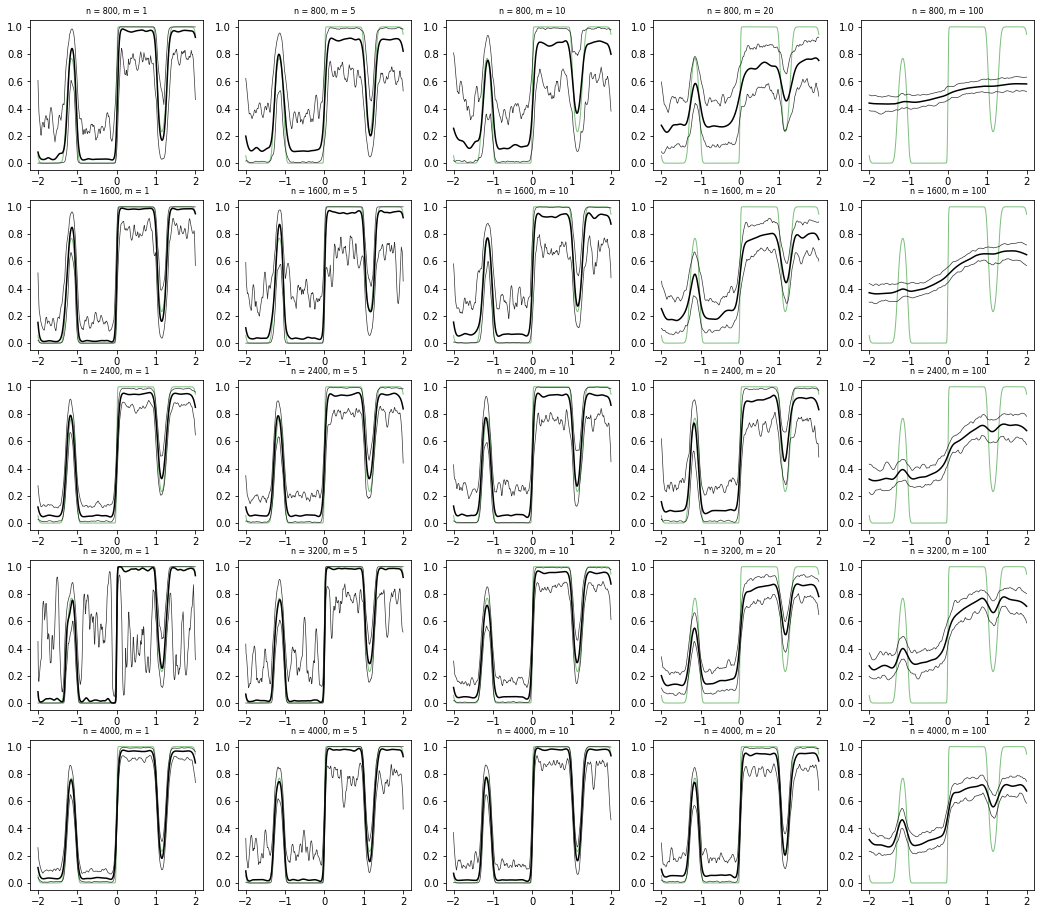

In [36]:
To_graph(mode='naiveAvg',file_dic = file_dic, n_num = 5, m_num = 5)

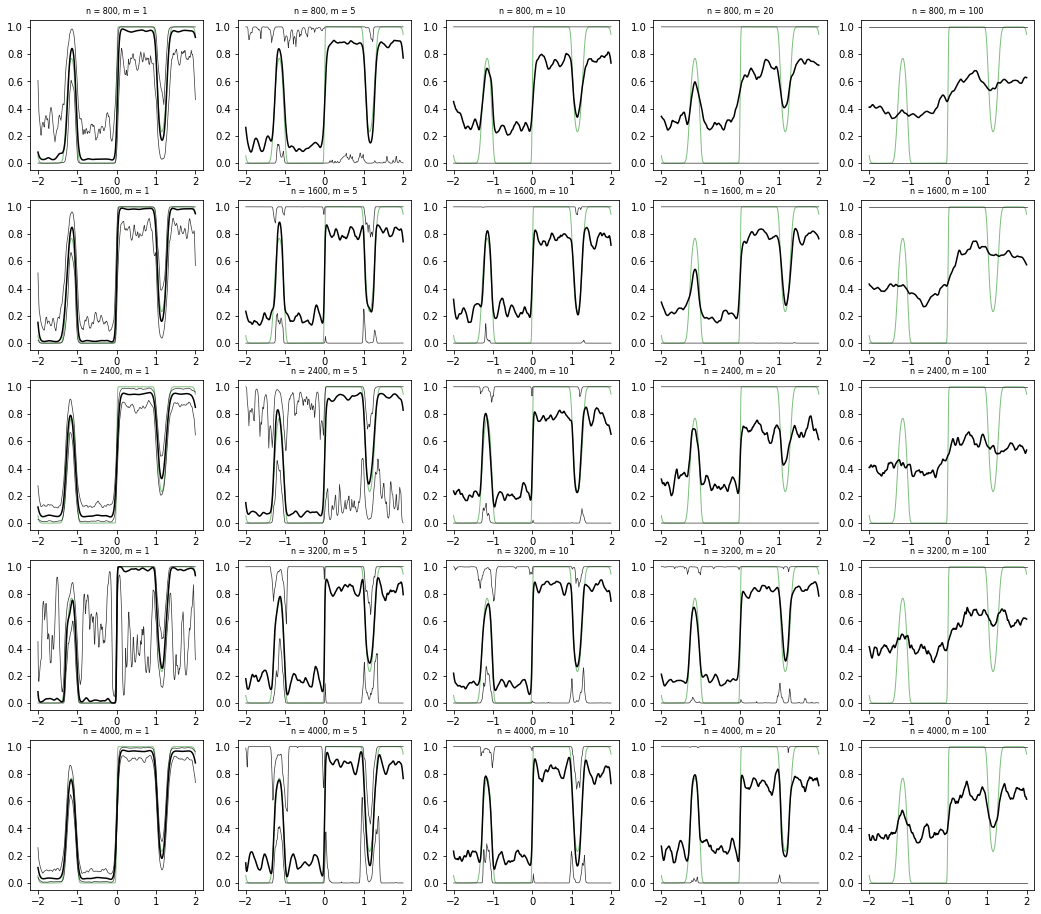

In [37]:
To_graph(mode ='adjPrior',file_dic = file_dic, n_num = 5, m_num = 5)

In [38]:
## graph with naive_avg and adj_prior 

# n_num = 5
# m_num = 4


# n = 10000
# xt = np.linspace(-2,2, n)
# xt, yt,pt,_,_,_ = get_train_test(train_size = n, test_size = 300, funct = 1, interval = (-2,2), seed = 123)
# xt, pt = zip(*sorted(zip(xt, pt)))
# rows = [i for i in range(n_num)]
# cols = [i for i in range(m_num)]
# indices = list(itertools.product(*[rows, cols]))

# fig, axs = plt.subplots(5, 4, figsize=(18, 16))
# fig.suptitle(f'Mode: NaiveAvg & AdjPrior')
# method = file_dic['naiveAvg']
# method2 = file_dic['adjPrior']





# for keys, ind in zip(method,indices):
#   n,m = keys
#   r,c = ind
#   x_sort, p, mean, cov  = method[keys]['pre_p_sort']
#   x_sort2, p2, mean2, cov2  = method2[keys]['pre_p_sort']

#   axs[r,c].plot(xt,pt,"-g", label='True',alpha = 0.5,linewidth= 1)

#   axs[r,c].plot(x_sort,p, "-k", label = 'naiveAvg',linewidth= 0.6)
#   #opecity_plt(mean = mean, cov = cov, test_x = x_sort, ax = axs[r,c], col = "-k", simu_num = 200,seed = 123)

#   axs[r,c].plot(x_sort2,p2, "-b", label='adjPrior',linewidth= 0.6)
#   #opecity_plt(mean = mean2, cov = cov2, test_x = x_sort2, ax = axs[r,c], col = "-b", simu_num = 200,seed = 123)

#   axs[r,c].set_title(f'n = {n}, m = {m}', size=8)
#   axs[r,c].legend(loc='lower right',prop={'size': 7})



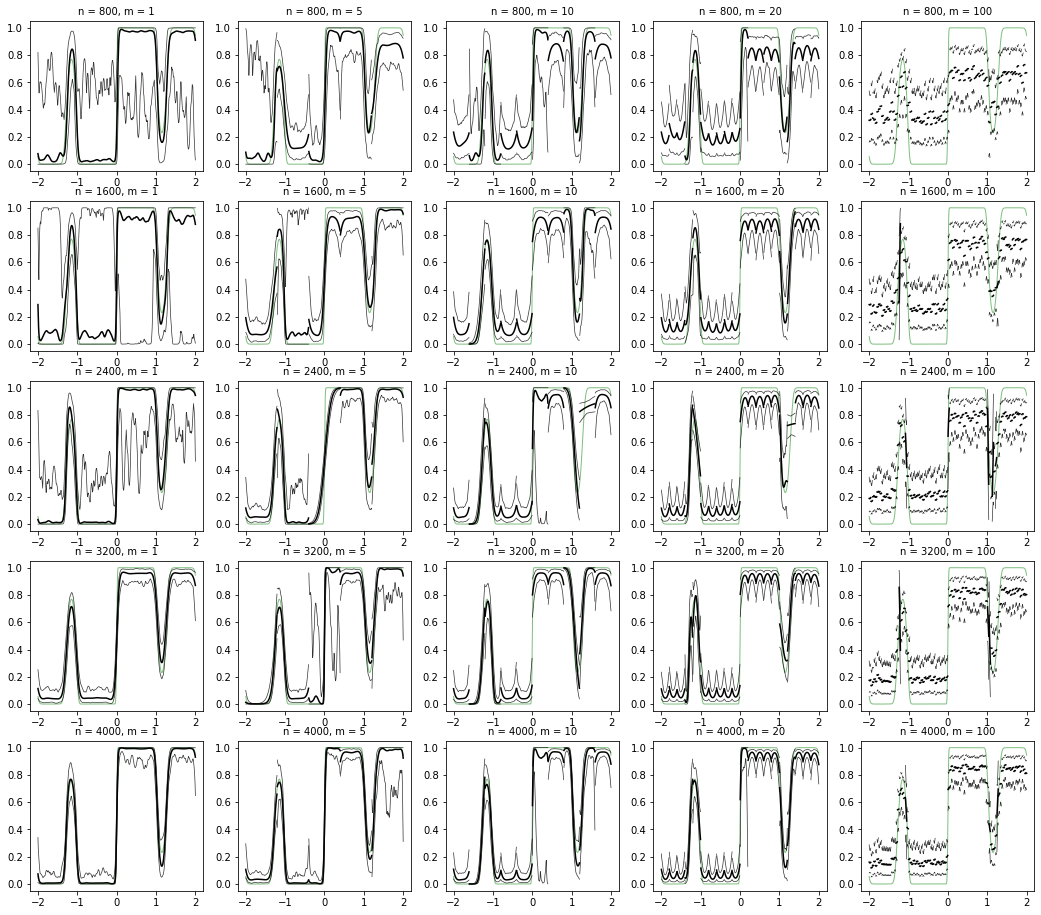

In [53]:
To_graph(mode ='spa',file_dic =file_dic, n_num = 5, m_num = 5)

# Implementation2

In [54]:
data_container = {1000:None,1600:None,2400:None,3200:None,4000:None}
test_size = 500


for n in data_container:
  data = get_train_test_spa(train_size = n, test_size = test_size, funct = 1, interval = (-2,2), seed = 128)
  data_container[n] = data

In [55]:
mode = "spa"
cons = [True, False]
machine = [1,5,10,20,50]
result_container = dict()
for con in cons:
  for n, data in data_container.items():
    for m in machine:
      train_x, train_y, train_p, test_x, test_y, test_p = data
      rslt = main_fun(train_x, train_y, test_x,test_y,mode = mode, machine_num = m, spa_equal_region = con)
      result_container[(n,m)] = rslt

      print(f"\n We finished in con = {con}, n = {n}, m = {m}: Time:{round(rslt['time'],2)}\n")



      # if n == 3000:
      #   with open(f'rslt_{mode}_3000.pickle', 'wb') as handle:
      #     pickle.dump(result_container, handle)


  with open(f'rslt_{mode}_{con}_4000.pickle', 'wb') as handle:
      pickle.dump(result_container, handle)
  result_container = dict()

having zero to 2? [False, False, False]
The interval is: [inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 1: Time:102.92

having zero to 2? [False, False, False]
The interval is: [-1.2 -0.4  0.4  1.2  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 5: Time:44.13

having zero to 2? [False, False, False]
The interval is: [-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 10: Time:44.63

having zero to 2? [False, False, False]
The interval is: [-1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 1000, m = 20: Time:58.26

having zero to 2? [False, False, True]
The interval is: [-1.9 -1.8 -1.8 -1.7 -1.6 -1.5 -1.4 -1.4 -1.3 -1.2 -1.1 -1.  -1.  -0.9
 -0.8 -0.7 -0.6 -0.6 -0.5 -0.4 -0.3 -0.2 -0.2 -0.1  0.   0.1  

 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(30, 1)]
having zero to 2? [False, False, False]

 We finished in con = True, n = 4000, m = 1: Time:2095.6

having zero to 2? [False, False, False]
The interval is: [-1.2 -0.4  0.4  1.2  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 4000, m = 5: Time:460.26

having zero to 2? [False, False, False]
The interval is: [-1.6 -1.2 -0.8 -0.4  0.   0.4  0.8  1.2  1.6  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 4000, m = 10: Time:261.89

having zero to 2? [False, False, False]
The interval is: [-1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4 -0.2  0.   0.2  0.4  0.6  0.8
  1.   1.2  1.4  1.6  1.8  inf]
having zero to 2? [False, False, False]

 We finished in con = True, n = 4000, m = 20: Time:173.16

having zero to 2? [False, False, False]
The interval is: [-1.9 -1.8 -1.8 -1.7 -1.6 -1.5 -1.4 -1.4 -1.3 -1.2 -1.1 -1.  -1.  -0.9
 -0.8 -0.7 -0.6 -0.6 -0.5 -0.4 -0.3 -0.2 -0.2 -0.1  0.   0.1  0.2  0.2
  0.3  0.4 

 /usr/local/lib/python3.7/dist-packages/GPy/inference/latent_function_inference/laplace.py:333: RuntimeWarning:invalid value encountered in sqrt


The hyperpar with exception: [(30, 1)]
the size for each machines [4000]

 We finished in con = False, n = 4000, m = 1: Time:2074.56

the size for each machines [801, 800, 800, 800, 799]
The interval is: [-0.7 -0.2  0.2  0.7  inf]
the size for each machines [801, 800, 800, 800, 799]

 We finished in con = False, n = 4000, m = 5: Time:298.35

the size for each machines [401, 400, 400, 400, 400, 400, 400, 400, 400, 399]
The interval is: [-1.  -0.7 -0.4 -0.2  0.   0.2  0.4  0.7  1.   inf]
the size for each machines [401, 400, 400, 400, 400, 400, 400, 400, 400, 399]

 We finished in con = False, n = 4000, m = 10: Time:179.34

the size for each machines [201, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 199]
The interval is: [-1.3 -1.  -0.8 -0.7 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.7  0.8  1.   1.3  inf]
the size for each machines [201, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200, 200,

# Result

## Table

In [56]:

filename = ['rslt_spa_True_4000.pickle', 'rslt_spa_False_4000.pickle']

file_dic = {'spa_True':None, 'spa_False':None}

for i, key in zip(range(2),file_dic):
  with open(filename[i], "rb") as f:
      dictname = pickle.load(f)
      print(f"key is {key}; filename is {filename[i]}")
      file_dic[key] = dictname

key is spa_True; filename is rslt_spa_True_4000.pickle
key is spa_False; filename is rslt_spa_False_4000.pickle


In [57]:
df1 = to_df(file_dic['spa_True'])
print(df1.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &   m = 1 &   m = 5 &  m = 10 &  m = 20 &  m = 50 \\
\midrule
n = 1000 &  102.92 &   44.13 &   44.63 &   58.26 &    75.8 \\
n = 1600 &  242.18 &    93.9 &   69.98 &   73.12 &   90.13 \\
n = 2400 &  559.82 &  180.95 &  111.51 &  114.53 &  125.93 \\
n = 3200 &  1165.8 &  297.42 &  180.09 &  145.37 &  159.32 \\
n = 4000 &  2095.6 &  460.26 &  261.89 &  173.16 &  184.08 \\
\bottomrule
\end{tabular}



In [58]:
df1 = to_df(file_dic['spa_True'], time = False)
print(df1.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                           m = 1 &                           m = 5 &                          m = 10 &                          m = 20 &                          m = 50 \\
\midrule
n = 1000 &  (FPR: 5.98, FNR:6.83, MCR:6.4) &  (FPR: 6.37, FNR:6.43, MCR:6.4) &  (FPR: 5.98, FNR:6.83, MCR:6.4) &  (FPR: 8.37, FNR:6.43, MCR:7.4) &  (FPR: 6.77, FNR:6.43, MCR:6.6) \\
n = 1600 &  (FPR: 6.83, FNR:5.58, MCR:6.2) &  (FPR: 8.03, FNR:4.38, MCR:6.2) &  (FPR: 6.83, FNR:5.18, MCR:6.0) &  (FPR: 6.43, FNR:6.37, MCR:6.4) &  (FPR: 6.43, FNR:5.58, MCR:6.0) \\
n = 2400 &  (FPR: 5.26, FNR:7.91, MCR:6.6) &  (FPR: 6.07, FNR:7.51, MCR:6.8) &  (FPR: 6.48, FNR:7.51, MCR:7.0) &  (FPR: 4.86, FNR:7.91, MCR:6.4) &  (FPR: 5.67, FNR:7.51, MCR:6.6) \\
n = 3200 &  (FPR: 5.69, FNR:6.69, MCR:6.2) &  (FPR: 6.91, FNR:5.51, MCR:6.2) &  (FPR: 5.28, FNR:6.69, MCR:6.0) &  (FPR: 8.13, FNR:5.51, MCR:6.8) &   (FPR: 6.5, FNR:5.91, MCR:6.2) \\
n = 4000 &  (FPR: 4.47, FNR:5.91, MCR:5.2) &   (FPR: 4

In [59]:
df2 = to_df(file_dic['spa_False'])
print(df2.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &    m = 1 &   m = 5 &  m = 10 &  m = 20 &  m = 50 \\
\midrule
n = 1000 &   100.55 &   40.14 &    54.6 &   48.28 &   71.98 \\
n = 1600 &   241.23 &   67.95 &   62.89 &   53.42 &   73.75 \\
n = 2400 &   556.17 &  123.28 &    93.6 &  109.18 &  114.73 \\
n = 3200 &  1131.35 &  203.08 &  134.58 &  128.34 &  119.82 \\
n = 4000 &  2074.56 &  298.35 &  179.34 &  144.56 &  130.61 \\
\bottomrule
\end{tabular}



In [60]:
df2 = to_df(file_dic['spa_False'], time = False)
print(df2.to_latex(index=True))  

\begin{tabular}{llllll}
\toprule
{} &                           m = 1 &                           m = 5 &                          m = 10 &                          m = 20 &                          m = 50 \\
\midrule
n = 1000 &  (FPR: 5.98, FNR:6.83, MCR:6.4) &  (FPR: 6.37, FNR:7.63, MCR:7.0) &  (FPR: 6.37, FNR:8.03, MCR:7.2) &  (FPR: 6.77, FNR:6.43, MCR:6.6) &  (FPR: 7.17, FNR:6.83, MCR:7.0) \\
n = 1600 &  (FPR: 6.83, FNR:5.58, MCR:6.2) &  (FPR: 6.43, FNR:5.18, MCR:5.8) &  (FPR: 6.83, FNR:5.58, MCR:6.2) &  (FPR: 7.23, FNR:4.78, MCR:6.0) &  (FPR: 8.03, FNR:5.98, MCR:7.0) \\
n = 2400 &  (FPR: 5.26, FNR:7.91, MCR:6.6) &  (FPR: 6.48, FNR:7.51, MCR:7.0) &  (FPR: 6.07, FNR:7.91, MCR:7.0) &   (FPR: 5.26, FNR:8.3, MCR:6.8) &  (FPR: 5.67, FNR:6.72, MCR:6.2) \\
n = 3200 &  (FPR: 5.69, FNR:6.69, MCR:6.2) &   (FPR: 5.28, FNR:6.3, MCR:5.8) &   (FPR: 6.1, FNR:5.91, MCR:6.0) &   (FPR: 5.69, FNR:6.3, MCR:6.0) &  (FPR: 4.88, FNR:5.51, MCR:5.2) \\
n = 4000 &  (FPR: 4.47, FNR:5.91, MCR:5.2) &  (FPR: 4.

coverage rate

In [61]:
df1 = get_coverge('spa_True',file_dic = file_dic)
print(df1.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 50 \\
\midrule
n = 1000 &  100.0 &   88.2 &    28.0 &    16.6 &    16.2 \\
n = 1600 &  100.0 &   48.8 &    50.4 &    18.2 &    17.6 \\
n = 2400 &  100.0 &   96.0 &    36.0 &    21.6 &    18.0 \\
n = 3200 &   26.8 &   73.0 &    32.0 &    20.6 &    16.6 \\
n = 4000 &   99.6 &   66.0 &    44.2 &    21.6 &    17.0 \\
\bottomrule
\end{tabular}



In [62]:
df2 = get_coverge('spa_False',file_dic = file_dic)
print(df2.to_latex(index=True))  

\begin{tabular}{lrrrrr}
\toprule
{} &  m = 1 &  m = 5 &  m = 10 &  m = 20 &  m = 50 \\
\midrule
n = 1000 &  100.0 &   44.0 &    38.4 &    38.6 &    20.8 \\
n = 1600 &  100.0 &   76.4 &    56.2 &    22.2 &    18.0 \\
n = 2400 &  100.0 &   42.8 &    63.4 &    16.0 &    21.2 \\
n = 3200 &   26.8 &   43.0 &    64.4 &    25.0 &    19.4 \\
n = 4000 &   99.6 &   70.0 &    53.2 &    21.0 &    20.4 \\
\bottomrule
\end{tabular}



##Graph

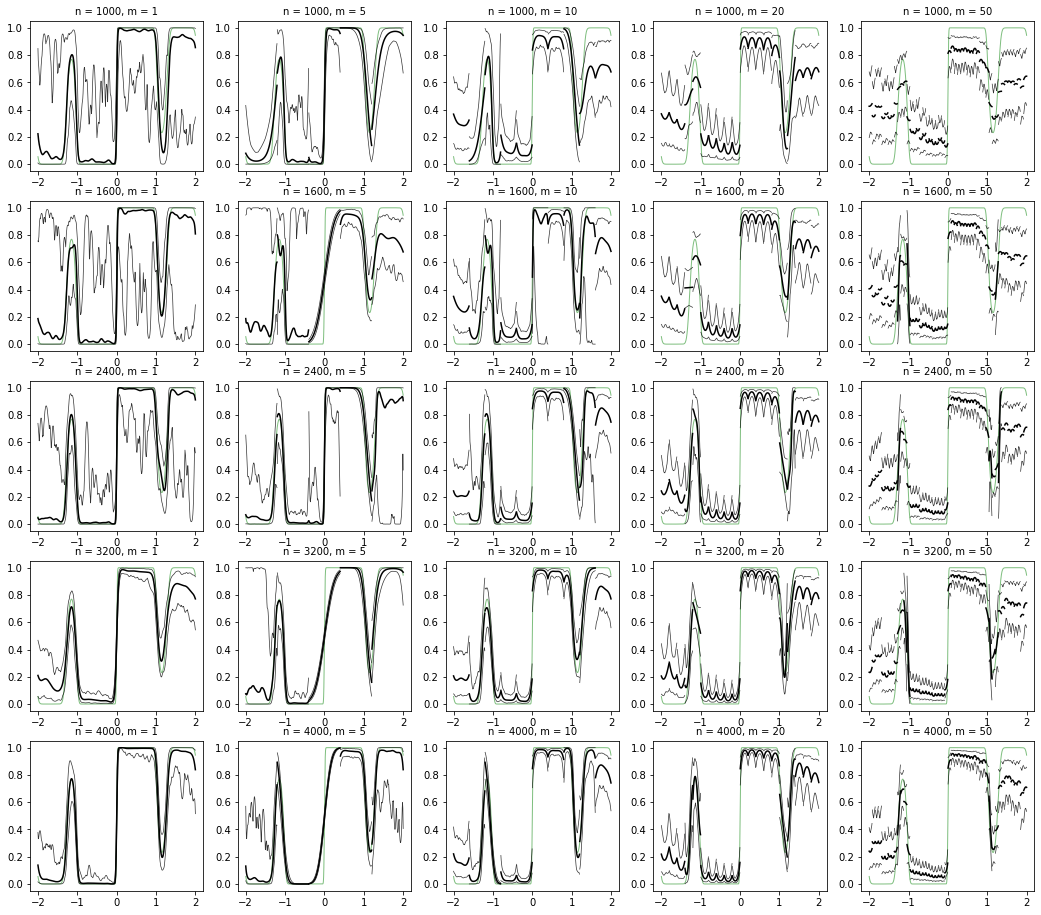

In [63]:
To_graph(mode='spa_True',file_dic = file_dic,n_num = 5, m_num = 5)

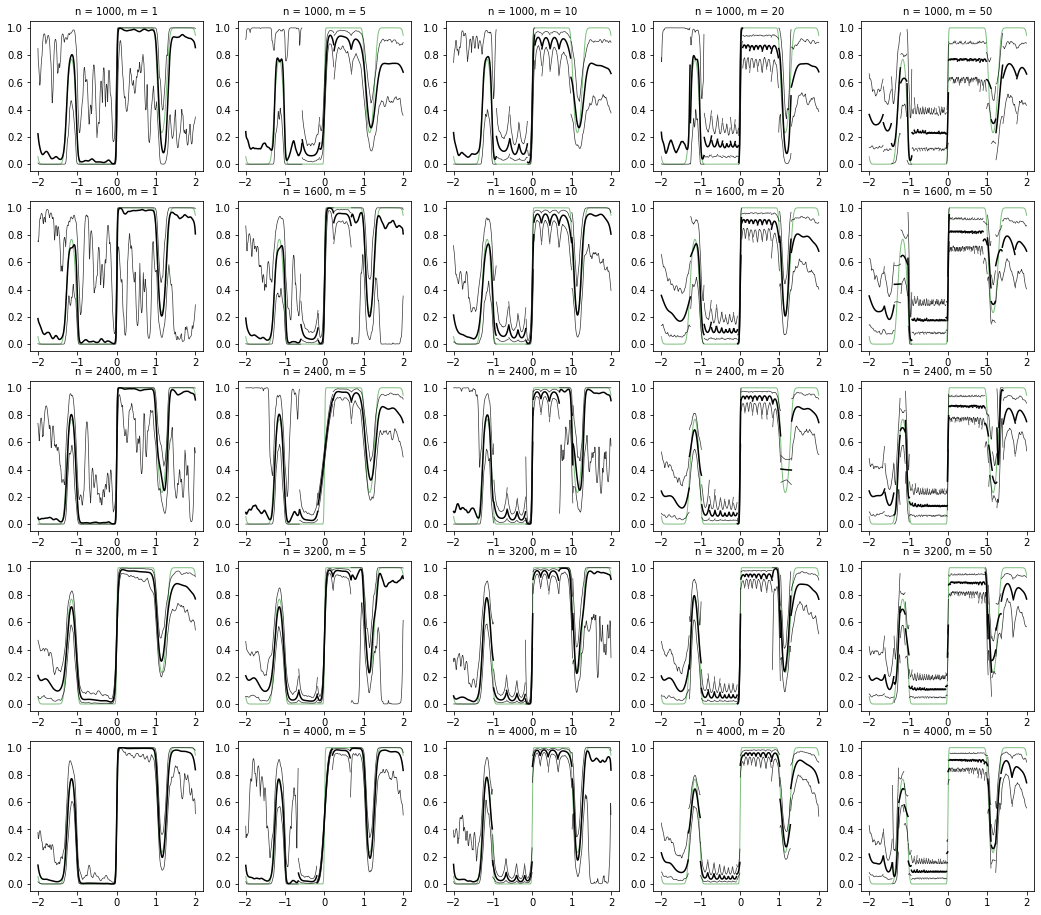

In [64]:
To_graph(mode='spa_False',file_dic = file_dic,n_num = 5, m_num = 5)